In [1]:
import json
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from IPython.display import Markdown as md

## Read dataset

In [2]:
data_list = glob.glob(os.path.join('../tracking_dataset_v01-02/', "*.json"))

In [3]:
train_list = glob.glob(os.path.join('../tracking_dataset_v01-02/train/', '*.json'))
valid_list = glob.glob(os.path.join('../tracking_dataset_v01-02/validation/', '*.json'))
test_list = glob.glob(os.path.join('../tracking_dataset_v01-02/test/', '*.json'))
full_list = train_list + valid_list + test_list
data_lists = [full_list, train_list, valid_list, test_list]
list_counts = [len(list) for list in data_lists]
set_keys = ['Total', 'Train', 'Validation', 'Test']

In [4]:
kick_list = []
for data_item in full_list:

    with open(data_item, 'r') as input_file:
        track_dict = json.load(input_file)

    start_time = track_dict['0']['time']
    start_pos = track_dict['0']['gt_ball_global']
    kick_data = np.array([[start_time,*start_pos]])

    for step in list(track_dict.values())[1:]:
        kick_data = np.concatenate([kick_data, np.asarray([[step['time'],*step['gt_ball_global']]])], axis=0)

    kick_data = kick_data-kick_data[0]
    kick_list.append(kick_data)

## Process dataset

In [5]:
kick_heights = []
kick_dists = []
time_steps = [0,0,0,0]
kick_type = {'Ground':[0,0,0,0], 'Loft':[0,0,0,0]}

GROUND_THRES = 0.04

for count, kick in enumerate(kick_list):
    subset = 1 + count//list_counts[1] + count//(list_counts[1]+list_counts[2])

    kick_height = np.max(kick[...,-1])
    kick_heights.append(kick_height)
    kick_dists.append(np.linalg.norm([kick[-1,1], kick[-1,1]], axis=0))
    time_steps[0] = time_steps[0] + kick.shape[0]
    time_steps[subset] = time_steps[subset] + kick.shape[0]

    if kick_height < GROUND_THRES:
        kick_type["Ground"][0] = kick_type["Ground"][0] + 1
        kick_type["Ground"][subset] = kick_type["Ground"][subset] + 1

    else: 
        kick_type["Loft"][0] = kick_type["Loft"][0] + 1
        kick_type["Loft"][subset] = kick_type["Loft"][subset] + 1

kick_heights = np.array(kick_heights)
kick_dists = np.array(kick_dists)

## Plot dataset

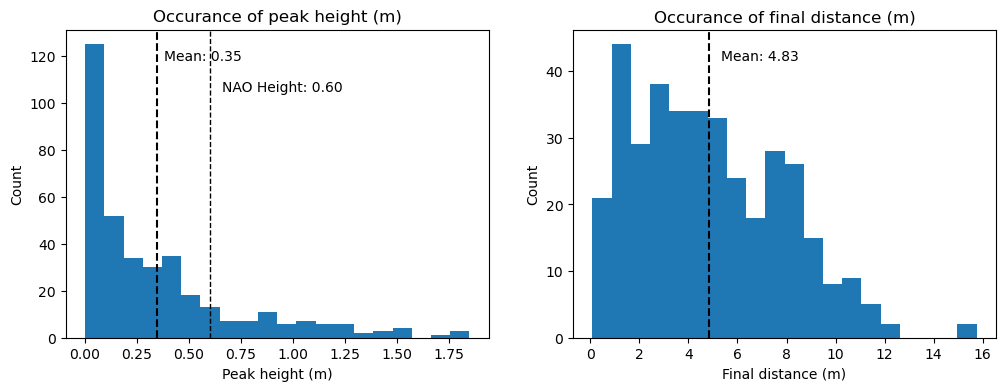

In [6]:
NAO_HEIGHT = 0.6
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=False)
ax=axes.ravel()

ax[0].hist(kick_heights, bins=20)
ax[0].set_title("Occurance of peak height (m)")
ax[0].set_xlabel("Peak height (m)")
ax[0].set_ylabel("Count")
min_ylim, max_ylim = ax[0].axis()[-2:]
ax[0].axvline(kick_heights.mean(), color='k', linestyle='dashed', linewidth=1.5)
ax[0].text(kick_heights.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(kick_heights.mean()))
ax[0].axvline(NAO_HEIGHT, color='k', linestyle='dashed', linewidth=1)
ax[0].text(NAO_HEIGHT*1.1, max_ylim*0.8, 'NAO Height: {:.2f}'.format(NAO_HEIGHT))

ax[1].hist(kick_dists, bins=20)
ax[1].set_title("Occurance of final distance (m)")
ax[1].set_xlabel("Final distance (m)")
ax[1].set_ylabel("Count")
min_ylim, max_ylim = ax[1].axis()[-2:]
ax[1].axvline(kick_dists.mean(), color='k', linestyle='dashed', linewidth=1.5)
ax[1].text(kick_dists.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(kick_dists.mean()))

plt.show()

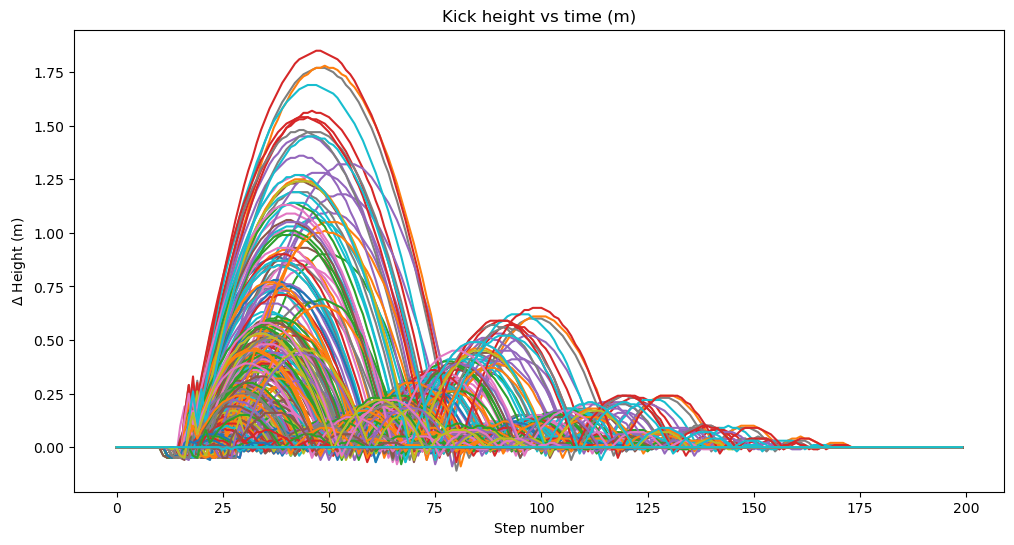

In [7]:
#plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Blues(np.linspace(0,1, len(kick_list))))
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6), sharey=False)
for kick in kick_list[:]:
    ax.plot(kick[:200,-1])
ax.set_title("Kick height vs time (m)")
ax.set_xlabel("Step number")
ax.set_ylabel("$\Delta$ Height (m)")

plt.show()

In [8]:
def p_tot(num):
    return num/list_counts[0]*100

In [9]:
def p_set(num, idx):
    return num[idx]/list_counts[idx]*100    

In [10]:
def cnt_set(num, idx):
    return num[idx]/list_counts[idx] 

In [11]:
type_keys = list(kick_type.keys())
type_vals = list(kick_type.values())

In [12]:
table = (
    'Total', list_counts[0], p_tot(list_counts[0]), cnt_set(time_steps,0), p_set(type_vals[0],0), p_set(type_vals[1],0),
    'Train', list_counts[1], p_tot(list_counts[1]), cnt_set(time_steps,1), p_set(type_vals[0],1), p_set(type_vals[1],1),
    'Val',   list_counts[2], p_tot(list_counts[2]), cnt_set(time_steps,2), p_set(type_vals[0],2), p_set(type_vals[1],2),
    'Test',  list_counts[3], p_tot(list_counts[3]), cnt_set(time_steps,3), p_set(type_vals[0],3), p_set(type_vals[1],3),
)
md("""
| Dataset | No. Kicks | Split (%%) | Avg No. steps | Grounded (%%) | Lofted (%%) |
| --- | --- | --- | --- | --- | --- |
| %s | %i | %.1f | %.1f | %.1f | %.1f |
| %s | %i | %.1f | %.1f | %.1f | %.1f |
| %s | %i | %.1f | %.1f | %.1f | %.1f |
| %s | %i | %.1f | %.1f | %.1f | %.1f |
"""%((table)))


| Dataset | No. Kicks | Split (%) | Avg No. steps | Grounded (%) | Lofted (%) |
| --- | --- | --- | --- | --- | --- |
| Total | 370 | 100.0 | 295.4 | 20.3 | 79.7 |
| Train | 222 | 60.0 | 294.1 | 20.3 | 79.7 |
| Val | 73 | 19.7 | 296.5 | 19.2 | 80.8 |
| Test | 75 | 20.3 | 297.9 | 21.3 | 78.7 |
